# Classify signals using CNN

First, we import some Python packages and define the parameters of the image frames.

In [1]:
import numpy as np
from blimpy import read_header, Waterfall, Filterbank

%matplotlib inline
import matplotlib.pyplot as plt

import sys, os, glob
sys.path.append("../../setigen")
import setigen as stg

tsamp = 18.253611008
fch1 = 6095.214842353016
df = -2.7939677238464355e-06

fchans = 1024
tchans = 16

fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

Then, we load the model weights for each normalization method.

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
from keras.preprocessing import image

img_width, img_height = 32, 1024

dir = 'normalized_comparison'
sets = ['raw', 'normalized', 'normalized_excluded']

models = []
for set in sets:

    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    model_path = '/datax/scratch/bbrzycki/models/%s/%s.h5' % (dir, set)
    model.load_weights(model_path)
    
    models.append(model)
    
model_dict = dict(zip(sets, models))

Now, we can generate signals to test our models and see which normalization schemes work best. Note that since these are all synthetic and use ideal Gaussian background noise, these might perform differently for actual observations!

#### Classify sine pulsed signal

Period: 89.35 s
Drift Rate: 5.15 Hz/s
Level: 2.06
Width: 56.47 Hz


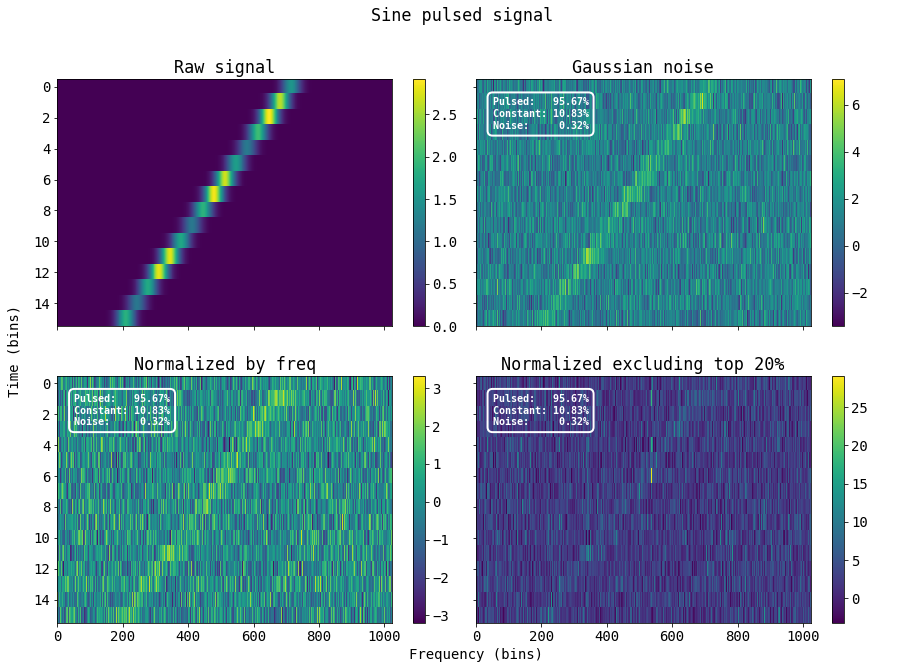

In [18]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))
#drift_rate = 0
level = np.random.uniform(2, 5)
width = np.random.uniform(0.02, 0.05) ** 3

amplitude = np.random.uniform(level/4, level)
# amplitude = level
period = np.random.uniform(50, 100)
# width = np.random.uniform(0.000009, 0.000225)

signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.sine_t_profile(period = period,
                                         phase = 0,
                                         amplitude = amplitude,
                                         level = level),
                      stg.gaussian_f_profile(width = width),
                      stg.constant_bp_profile(level = 1.0))

# fig = plt.figure(figsize=(10,6))
# plt.imshow(signal, aspect='auto')
# plt.colorbar()

print('Period: %.02f s' % period)
print('Drift Rate: %.02f Hz/s' % (drift_rate*1e6))
print('Level: %.02f' % level)
print('Width: %.02f Hz' % (width*1e6))

# SET FONT
plt.rcParams.update({'font.family': 'monospace', 'font.size': 14})

# row and column sharing
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10), sharex='col', sharey='row')

img1 = ax1.imshow(signal, aspect='auto')
plt.imsave('temp_no_noise.png', signal)
ax1.set_title('Raw signal')

raw = stg.inject_noise(signal)
ax2.imshow(raw, aspect='auto')
plt.imsave('temp_raw.png', raw)
ax2.set_title('Gaussian noise')

# model = model_dict['raw']
# img2 = load_img('temp_raw.png',False,target_size=(32,1024))
# x = img_to_array(img2)
# x = x / 255.
# x = np.expand_dims(x, axis=0)
# prob2 = model.predict_proba(x)[0]

normalized = stg.normalize(stg.inject_noise(signal), cols = 0, exclude = 0.0, use_median=False)
img3 = ax3.imshow(normalized, aspect='auto')
plt.imsave('temp_normalized.png', normalized)
ax3.set_title('Normalized by freq')

# model = model_dict['normalized']
# img3 = load_img('temp_normalized.png',False,target_size=(32,1024))
# x = img_to_array(img3)
# x = x / 255.
# x = np.expand_dims(x, axis=0)
# prob3 = model.predict_proba(x)[0]

normalized_excluded = stg.normalize(stg.inject_noise(signal), cols = 1, exclude = 0.2, use_median=False)
img4 = ax4.imshow(normalized_excluded, aspect='auto')
plt.imsave('temp_normalized_excluded.png', normalized_excluded)
ax4.set_title('Normalized excluding top 20%')

# model = model_dict['normalized_excluded']
# img4 = load_img('temp_normalized_excluded.png',False,target_size=(32,1024))
# x = img_to_array(img4)
# x = x / 255.
# x = np.expand_dims(x, axis=0)
# prob4 = model.predict_proba(x)[0]

prob2 = (0.9567, 0.1083, 0.0032)
prob3 = (0.9567, 0.1083, 0.0032)
prob4 = (0.9567, 0.1083, 0.0032)

if start_index < fchans / 2:
    x_pos = 0.66
else:
    x_pos = 0.05
    
text = '{pulsed:<9} {value1:>6}\n{constant:<9} {value2:>6}\n{noise:<9} {value3:>6}'.format(pulsed='Pulsed:',
                                                                                     value1='%.02f%%' % (prob2[0]*100),
                                                                                     constant='Constant:',
                                                                                     value2='%.02f%%' % (prob2[1]*100),
                                                                                     noise='Noise:',
                                                                                     value3='%.02f%%' % (prob2[2]*100))    
ax2.text(x_pos, 0.8, text, fontsize = 10, weight='bold', color='white', transform=ax2.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

text = '{pulsed:<9} {value1:>6}\n{constant:<9} {value2:>6}\n{noise:<9} {value3:>6}'.format(pulsed='Pulsed:',
                                                                                     value1='%.02f%%' % (prob3[0]*100),
                                                                                     constant='Constant:',
                                                                                     value2='%.02f%%' % (prob3[1]*100),
                                                                                     noise='Noise:',
                                                                                     value3='%.02f%%' % (prob3[2]*100))
ax3.text(x_pos, 0.8, text, fontsize = 10, weight='bold', color='white', transform=ax3.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

text = '{pulsed:<9} {value1:>6}\n{constant:<9} {value2:>6}\n{noise:<9} {value3:>6}'.format(pulsed='Pulsed:',
                                                                                     value1='%.02f%%' % (prob4[0]*100),
                                                                                     constant='Constant:',
                                                                                     value2='%.02f%%' % (prob4[1]*100),
                                                                                     noise='Noise:',
                                                                                     value3='%.02f%%' % (prob4[2]*100))
ax4.text(x_pos, 0.8, text, fontsize = 10, weight='bold', color='white', transform=ax4.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

fig.suptitle('Sine pulsed signal')
plt.xlabel('Frequency (bins)')
plt.ylabel('Time (bins)')

plt.colorbar(img1, ax = ax1)
plt.colorbar(img2, ax = ax2)
plt.colorbar(img3, ax = ax3)
plt.colorbar(img4, ax = ax4)
# plt.tight_layout()

fig.subplots_adjust(wspace = 0.0)

plt.show()

#### Classify constant signal

Drift Rate: -3.22 Hz/s
Level: 3.53
Width: 111.95 Hz


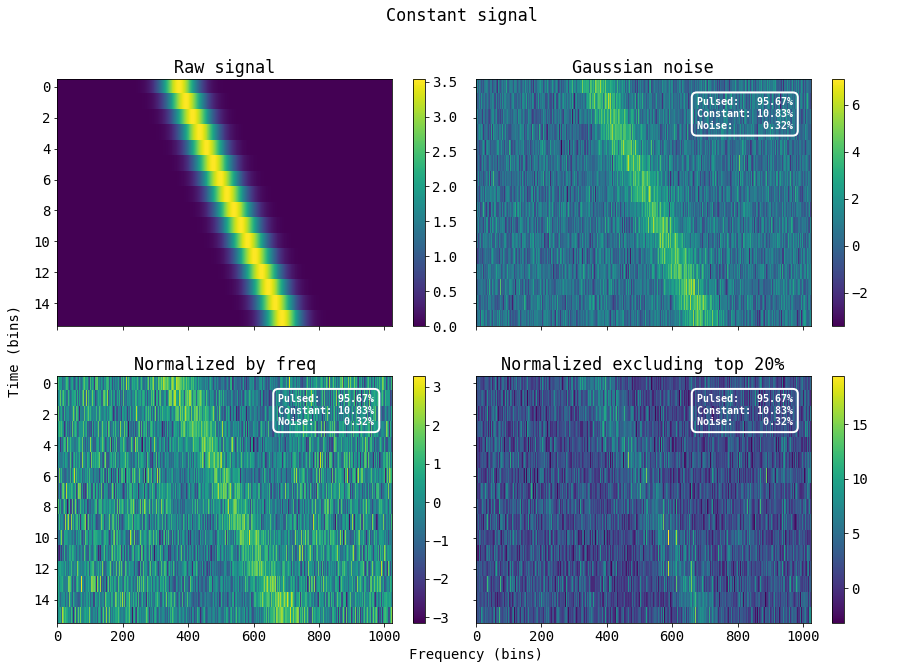

In [19]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))
level = np.random.uniform(2, 5)
width = np.random.uniform(0.02, 0.05) ** 3

signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                      stg.constant_t_profile(level = level),
                      stg.gaussian_f_profile(width = width),
                      stg.constant_bp_profile(level = 1.0))

# fig = plt.figure(figsize=(10,6))
# plt.imshow(signal, aspect='auto')
# plt.colorbar()

print('Drift Rate: %.02f Hz/s' % (drift_rate*1e6))
print('Level: %.02f' % level)
print('Width: %.02f Hz' % (width*1e6))

# SET FONT
plt.rcParams.update({'font.family': 'monospace', 'font.size': 14})

# row and column sharing
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10), sharex='col', sharey='row')

img1 = ax1.imshow(signal, aspect='auto')
plt.imsave('temp_no_noise.png', signal)
ax1.set_title('Raw signal')

raw = stg.inject_noise(signal)
ax2.imshow(raw, aspect='auto')
plt.imsave('temp_raw.png', raw)
ax2.set_title('Gaussian noise')

# model = model_dict['raw']
# img2 = load_img('temp_raw.png',False,target_size=(32,1024))
# x = img_to_array(img2)
# x = x / 255.
# x = np.expand_dims(x, axis=0)
# prob2 = model.predict_proba(x)[0]

normalized = stg.normalize(stg.inject_noise(signal), cols = 0, exclude = 0.0, use_median=False)
img3 = ax3.imshow(normalized, aspect='auto')
plt.imsave('temp_normalized.png', normalized)
ax3.set_title('Normalized by freq')

# model = model_dict['normalized']
# img3 = load_img('temp_normalized.png',False,target_size=(32,1024))
# x = img_to_array(img3)
# x = x / 255.
# x = np.expand_dims(x, axis=0)
# prob3 = model.predict_proba(x)[0]

normalized_excluded = stg.normalize(stg.inject_noise(signal), cols = 1, exclude = 0.2, use_median=False)
img4 = ax4.imshow(normalized_excluded, aspect='auto')
plt.imsave('temp_normalized_excluded.png', normalized_excluded)
ax4.set_title('Normalized excluding top 20%')

# model = model_dict['normalized_excluded']
# img4 = load_img('temp_normalized_excluded.png',False,target_size=(32,1024))
# x = img_to_array(img4)
# x = x / 255.
# x = np.expand_dims(x, axis=0)
# prob4 = model.predict_proba(x)[0]

prob2 = (0.9567, 0.1083, 0.0032)
prob3 = (0.9567, 0.1083, 0.0032)
prob4 = (0.9567, 0.1083, 0.0032)

if start_index < fchans / 2:
    x_pos = 0.66
else:
    x_pos = 0.05
    
text = '{pulsed:<9} {value1:>6}\n{constant:<9} {value2:>6}\n{noise:<9} {value3:>6}'.format(pulsed='Pulsed:',
                                                                                     value1='%.02f%%' % (prob2[0]*100),
                                                                                     constant='Constant:',
                                                                                     value2='%.02f%%' % (prob2[1]*100),
                                                                                     noise='Noise:',
                                                                                     value3='%.02f%%' % (prob2[2]*100))    
ax2.text(x_pos, 0.8, text, fontsize = 10, weight='bold', color='white', transform=ax2.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

text = '{pulsed:<9} {value1:>6}\n{constant:<9} {value2:>6}\n{noise:<9} {value3:>6}'.format(pulsed='Pulsed:',
                                                                                     value1='%.02f%%' % (prob3[0]*100),
                                                                                     constant='Constant:',
                                                                                     value2='%.02f%%' % (prob3[1]*100),
                                                                                     noise='Noise:',
                                                                                     value3='%.02f%%' % (prob3[2]*100))
ax3.text(x_pos, 0.8, text, fontsize = 10, weight='bold', color='white', transform=ax3.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

text = '{pulsed:<9} {value1:>6}\n{constant:<9} {value2:>6}\n{noise:<9} {value3:>6}'.format(pulsed='Pulsed:',
                                                                                     value1='%.02f%%' % (prob4[0]*100),
                                                                                     constant='Constant:',
                                                                                     value2='%.02f%%' % (prob4[1]*100),
                                                                                     noise='Noise:',
                                                                                     value3='%.02f%%' % (prob4[2]*100))
ax4.text(x_pos, 0.8, text, fontsize = 10, weight='bold', color='white', transform=ax4.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

fig.suptitle('Constant signal')
plt.xlabel('Frequency (bins)')
plt.ylabel('Time (bins)')

plt.colorbar(img1, ax = ax1)
plt.colorbar(img2, ax = ax2)
plt.colorbar(img3, ax = ax3)
plt.colorbar(img4, ax = ax4)
# plt.tight_layout()

fig.subplots_adjust(wspace = 0.0)

plt.show()

#### Classify noise

Drift Rate: -3.22 Hz/s
Level: 3.53
Width: 111.95 Hz


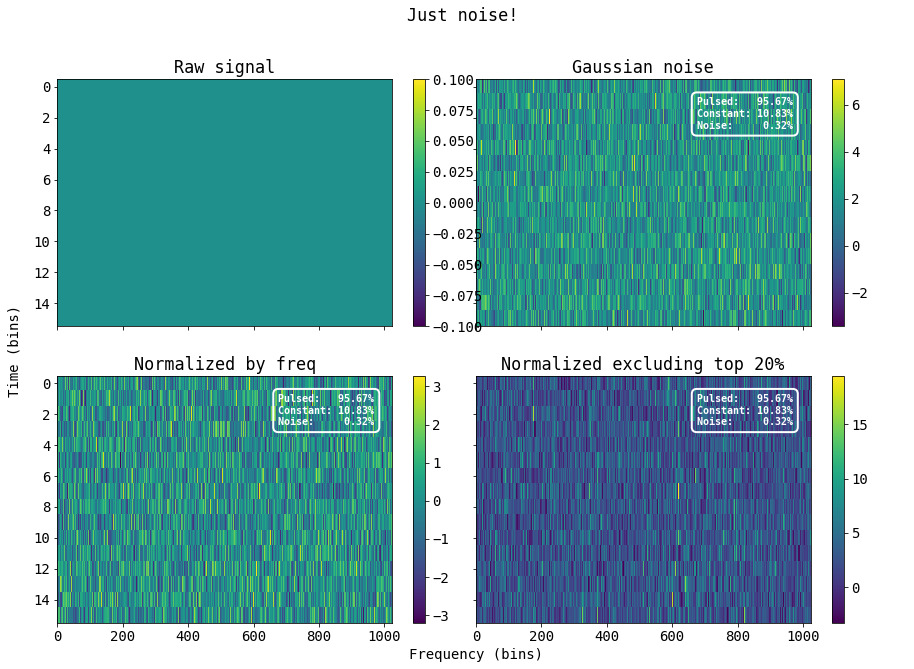

In [20]:
signal = stg.generate(ts,
                      fs,
                      stg.constant_path(f_start = fs[0], drift_rate = 0),
                      stg.constant_t_profile(level = 0),
                      stg.gaussian_f_profile(width = 0.00002),
                      stg.constant_bp_profile(level = 1.0))

# fig = plt.figure(figsize=(10,6))
# plt.imshow(signal, aspect='auto')
# plt.colorbar()

print('Drift Rate: %.02f Hz/s' % (drift_rate*1e6))
print('Level: %.02f' % level)
print('Width: %.02f Hz' % (width*1e6))

# SET FONT
plt.rcParams.update({'font.family': 'monospace', 'font.size': 14})

# row and column sharing
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10), sharex='col', sharey='row')

img1 = ax1.imshow(signal, aspect='auto')
plt.imsave('temp_no_noise.png', signal)
ax1.set_title('Raw signal')

raw = stg.inject_noise(signal)
ax2.imshow(raw, aspect='auto')
plt.imsave('temp_raw.png', raw)
ax2.set_title('Gaussian noise')

# model = model_dict['raw']
# img2 = load_img('temp_raw.png',False,target_size=(32,1024))
# x = img_to_array(img2)
# x = x / 255.
# x = np.expand_dims(x, axis=0)
# prob2 = model.predict_proba(x)[0]

normalized = stg.normalize(stg.inject_noise(signal), cols = 0, exclude = 0.0, use_median=False)
img3 = ax3.imshow(normalized, aspect='auto')
plt.imsave('temp_normalized.png', normalized)
ax3.set_title('Normalized by freq')

# model = model_dict['normalized']
# img3 = load_img('temp_normalized.png',False,target_size=(32,1024))
# x = img_to_array(img3)
# x = x / 255.
# x = np.expand_dims(x, axis=0)
# prob3 = model.predict_proba(x)[0]

normalized_excluded = stg.normalize(stg.inject_noise(signal), cols = 1, exclude = 0.2, use_median=False)
img4 = ax4.imshow(normalized_excluded, aspect='auto')
plt.imsave('temp_normalized_excluded.png', normalized_excluded)
ax4.set_title('Normalized excluding top 20%')

# model = model_dict['normalized_excluded']
# img4 = load_img('temp_normalized_excluded.png',False,target_size=(32,1024))
# x = img_to_array(img4)
# x = x / 255.
# x = np.expand_dims(x, axis=0)
# prob4 = model.predict_proba(x)[0]

prob2 = (0.9567, 0.1083, 0.0032)
prob3 = (0.9567, 0.1083, 0.0032)
prob4 = (0.9567, 0.1083, 0.0032)

if start_index < fchans / 2:
    x_pos = 0.66
else:
    x_pos = 0.05
    
text = '{pulsed:<9} {value1:>6}\n{constant:<9} {value2:>6}\n{noise:<9} {value3:>6}'.format(pulsed='Pulsed:',
                                                                                     value1='%.02f%%' % (prob2[0]*100),
                                                                                     constant='Constant:',
                                                                                     value2='%.02f%%' % (prob2[1]*100),
                                                                                     noise='Noise:',
                                                                                     value3='%.02f%%' % (prob2[2]*100))    
ax2.text(x_pos, 0.8, text, fontsize = 10, weight='bold', color='white', transform=ax2.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

text = '{pulsed:<9} {value1:>6}\n{constant:<9} {value2:>6}\n{noise:<9} {value3:>6}'.format(pulsed='Pulsed:',
                                                                                     value1='%.02f%%' % (prob3[0]*100),
                                                                                     constant='Constant:',
                                                                                     value2='%.02f%%' % (prob3[1]*100),
                                                                                     noise='Noise:',
                                                                                     value3='%.02f%%' % (prob3[2]*100))
ax3.text(x_pos, 0.8, text, fontsize = 10, weight='bold', color='white', transform=ax3.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

text = '{pulsed:<9} {value1:>6}\n{constant:<9} {value2:>6}\n{noise:<9} {value3:>6}'.format(pulsed='Pulsed:',
                                                                                     value1='%.02f%%' % (prob4[0]*100),
                                                                                     constant='Constant:',
                                                                                     value2='%.02f%%' % (prob4[1]*100),
                                                                                     noise='Noise:',
                                                                                     value3='%.02f%%' % (prob4[2]*100))
ax4.text(x_pos, 0.8, text, fontsize = 10, weight='bold', color='white', transform=ax4.transAxes,
        bbox=dict(facecolor='none', edgecolor='white', linewidth=2, boxstyle='round,pad=0.5'))

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)

fig.suptitle('Just noise!')
plt.xlabel('Frequency (bins)')
plt.ylabel('Time (bins)')

plt.colorbar(img1, ax = ax1)
plt.colorbar(img2, ax = ax2)
plt.colorbar(img3, ax = ax3)
plt.colorbar(img4, ax = ax4)
# plt.tight_layout()

fig.subplots_adjust(wspace = 0.0)

plt.show()

#### Look at actual data!